# 数据加载、时间序列转换与可视化

本 notebook 从已保存的 CSV 文件加载数据，转换为时间序列格式（适配 pysindy），并进行可视化

In [16]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools.tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from tools.tools import split_and_group_matrices, plot_macro_serie
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from read_data_improved import main, format_timeseries_data

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 步骤 1: 生成并保存数据

In [2]:
print("="*60)
print("生成训练和测试数据...")
print("="*60)
main()

生成训练和测试数据...
EEG 数据处理流程
正在读取数据文件: ./IPCAS_ExemplarData_ZXL_Sub14.mat
  EEG 数据形状: (5876180, 141)
  试验类型: [1. 2. 3. 4.]
  注意力类型: [1. 2.]
  时间标记数: 864

筛选条件: attenType=1, trialType=1
  匹配的试验数: 144
  成功提取: 144 个数据段

正在标准化数据...
  标准化完成: 144 个样本

划分训练/测试集:
  总样本数: 144
  训练集: 139 (96.5%)
  测试集: 5 (3.5%)

处理阶段 1

训练集:
  已保存: ./visual_inducted_conscious/1/stage1/train_input.csv
         ./visual_inducted_conscious/1/stage1/train_target.csv
         形状: input (83261, 141), target (83261, 141)

测试集:
  已保存: ./visual_inducted_conscious/1/stage1/test_input.csv
         ./visual_inducted_conscious/1/stage1/test_target.csv
         形状: input (2995, 141), target (2995, 141)

处理阶段 2

训练集:
  已保存: ./visual_inducted_conscious/1/stage2/train_input.csv
         ./visual_inducted_conscious/1/stage2/train_target.csv
         形状: input (83261, 141), target (83261, 141)

测试集:
  已保存: ./visual_inducted_conscious/1/stage2/test_input.csv
         ./visual_inducted_conscious/1/stage2/test_target.csv
         形状: inpu

## 步骤 2: 从 CSV 文件加载数据

In [3]:
print("\n" + "="*60)
print("加载保存的数据...")
print("="*60)

train_data = {}
test_data = {}

for stage in [1, 2, 3]:
    base_path = f'./visual_inducted_conscious/1/stage{stage}'
    
    train_input = pd.read_csv(f'{base_path}/train_input.csv', header=None).values
    train_target = pd.read_csv(f'{base_path}/train_target.csv', header=None).values
    train_data[stage] = {'input': train_input, 'target': train_target}
    
    test_input = pd.read_csv(f'{base_path}/test_input.csv', header=None).values
    test_target = pd.read_csv(f'{base_path}/test_target.csv', header=None).values
    test_data[stage] = {'input': test_input, 'target': test_target}
    
    print(f"\nStage {stage} 数据已加载:")
    print(f"  训练集输入:  {train_input.shape}")
    print(f"  训练集目标:  {train_target.shape}")
    print(f"  测试集输入:  {test_input.shape}")
    print(f"  测试集目标:  {test_target.shape}")


加载保存的数据...

Stage 1 数据已加载:
  训练集输入:  (83261, 141)
  训练集目标:  (83261, 141)
  测试集输入:  (2995, 141)
  测试集目标:  (2995, 141)

Stage 2 数据已加载:
  训练集输入:  (83261, 141)
  训练集目标:  (83261, 141)
  测试集输入:  (2995, 141)
  测试集目标:  (2995, 141)

Stage 3 数据已加载:
  训练集输入:  (83261, 141)
  训练集目标:  (83261, 141)
  测试集输入:  (2995, 141)
  测试集目标:  (2995, 141)


## 步骤 3: 转换为时间序列格式（pysindy 格式）

In [4]:
print("\n" + "="*60)
print("转换为时间序列格式")
print("="*60)

DT = 0.001  # 时间步长（秒）
timeseries_data = {}

for stage in [1, 2, 3]:
    print(f"\n处理 Stage {stage}:")
    
    # 训练集转换
    X_train, t_train, X_dot_train = format_timeseries_data(
        train_data[stage]['input'],
        train_data[stage]['target'],
        dt=DT
    )
    
    # 测试集转换
    X_test, t_test, X_dot_test = format_timeseries_data(
        test_data[stage]['input'],
        test_data[stage]['target'],
        dt=DT
    )
    
    timeseries_data[stage] = {
        'train': {'X': X_train, 't': t_train, 'X_dot': X_dot_train},
        'test': {'X': X_test, 't': t_test, 'X_dot': X_dot_test}
    }
    
    print(f"  训练集: X {X_train.shape}, t {t_train.shape}, X_dot {X_dot_train.shape}")
    print(f"  测试集: X {X_test.shape}, t {t_test.shape}, X_dot {X_dot_test.shape}")

print(f"\n✓ 时间序列转换完成！")


转换为时间序列格式

处理 Stage 1:
  训练集: X (141, 83261), t (83261,), X_dot (141, 83261)
  测试集: X (141, 2995), t (2995,), X_dot (141, 2995)

处理 Stage 2:
  训练集: X (141, 83261), t (83261,), X_dot (141, 83261)
  测试集: X (141, 2995), t (2995,), X_dot (141, 2995)

处理 Stage 3:
  训练集: X (141, 83261), t (83261,), X_dot (141, 83261)
  测试集: X (141, 2995), t (2995,), X_dot (141, 2995)

✓ 时间序列转换完成！


## 步骤 4: 数据可视化 - 检查数据完整性

In [5]:
# 选择第一个阶段和第一个特征进行可视化
stage_to_plot = 1
feature_to_plot = 0  # 第一个特征（通道）

# 获取训练数据
X_train = timeseries_data[stage_to_plot]['train']['X']
t_train = timeseries_data[stage_to_plot]['train']['t']
X_dot_train = timeseries_data[stage_to_plot]['train']['X_dot']

print(f"\n可视化 Stage {stage_to_plot}，特征 {feature_to_plot}:")
print(f"  时间步数: {len(t_train)}")
print(f"  时间范围: [{t_train[0]:.4f}, {t_train[-1]:.4f}] 秒")
print(f"  特征范围: [{X_train[feature_to_plot].min():.4f}, {X_train[feature_to_plot].max():.4f}]")
print(f"  导数范围: [{X_dot_train[feature_to_plot].min():.4f}, {X_dot_train[feature_to_plot].max():.4f}]")


可视化 Stage 1，特征 0:
  时间步数: 83261
  时间范围: [0.0000, 83.2600] 秒
  特征范围: [-3.9210, 3.7248]
  导数范围: [-396.7335, 376.7069]


## 步骤 5: 绘制时间序列图

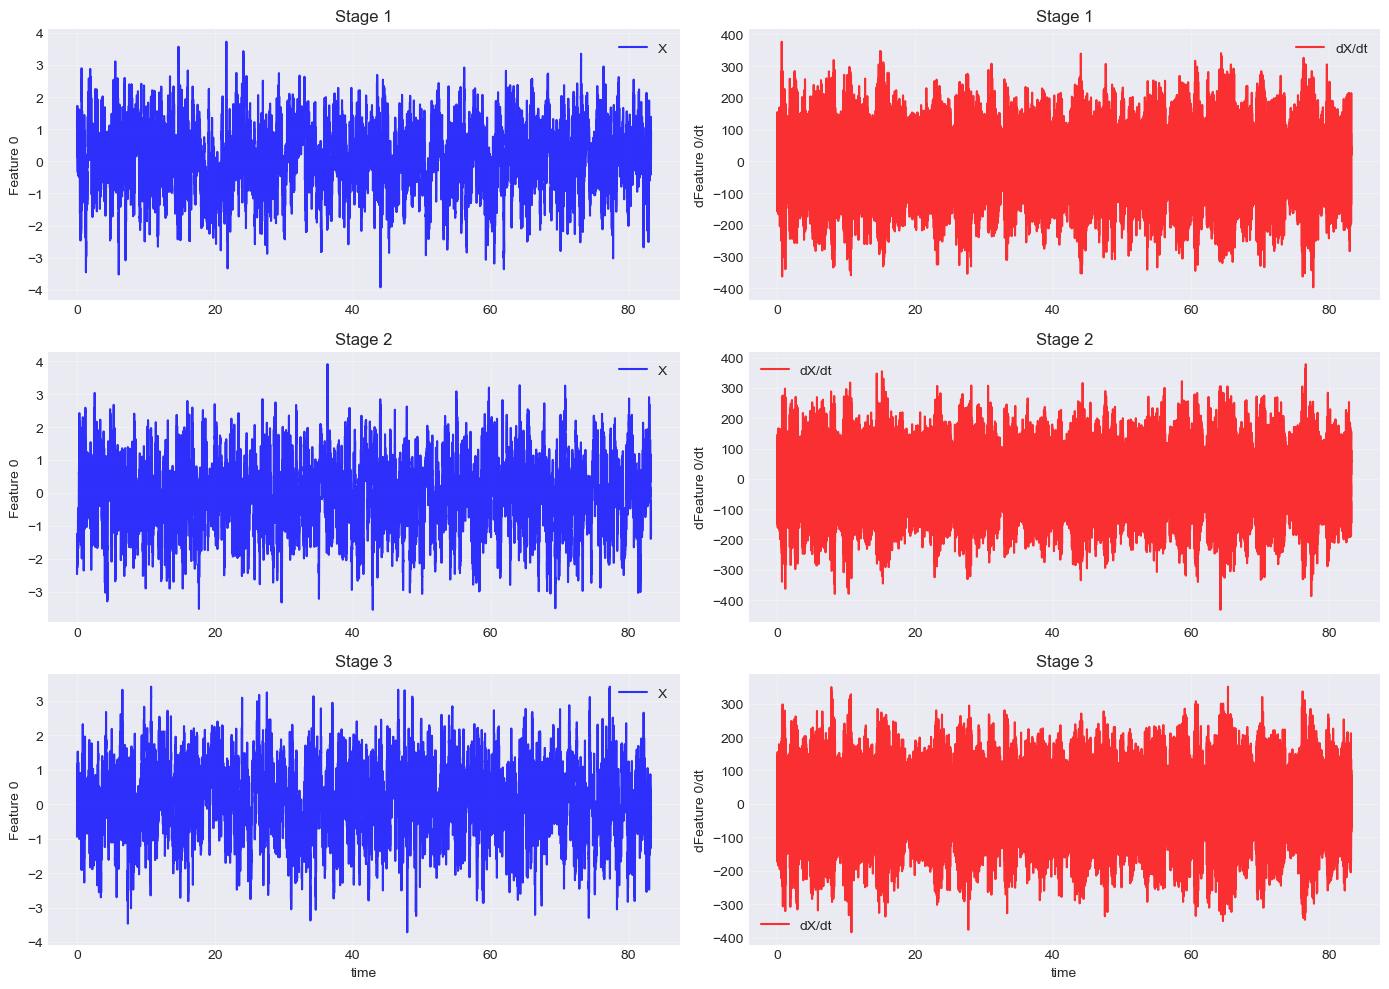

✓ 时间序列图绘制完成


In [10]:
# 绘制 3 个阶段的时间序列
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
feature = 0  # 只绘制第一个特征

for idx, stage in enumerate([1, 2, 3]):
    # 获取数据
    X_train = timeseries_data[stage]['train']['X']
    t_train = timeseries_data[stage]['train']['t']
    X_dot_train = timeseries_data[stage]['train']['X_dot']
    
    # 绘制特征值
    axes[idx, 0].plot(t_train, X_train[feature], 'b-', linewidth=1.5, alpha=0.8, label='X')
    axes[idx, 0].set_ylabel(f'Feature {feature}')
    axes[idx, 0].set_title(f'Stage {stage}')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].legend()
    
    # 绘制导数值
    axes[idx, 1].plot(t_train, X_dot_train[feature], 'r-', linewidth=1.5, alpha=0.8, label='dX/dt')
    axes[idx, 1].set_ylabel(f'dFeature {feature}/dt')
    axes[idx, 1].set_title(f'Stage {stage}')
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].legend()

axes[2, 0].set_xlabel('time')
axes[2, 1].set_xlabel('time')
plt.tight_layout()
plt.show()

print("✓ 时间序列图绘制完成")

## 步骤 6: 绘制相空间轨迹

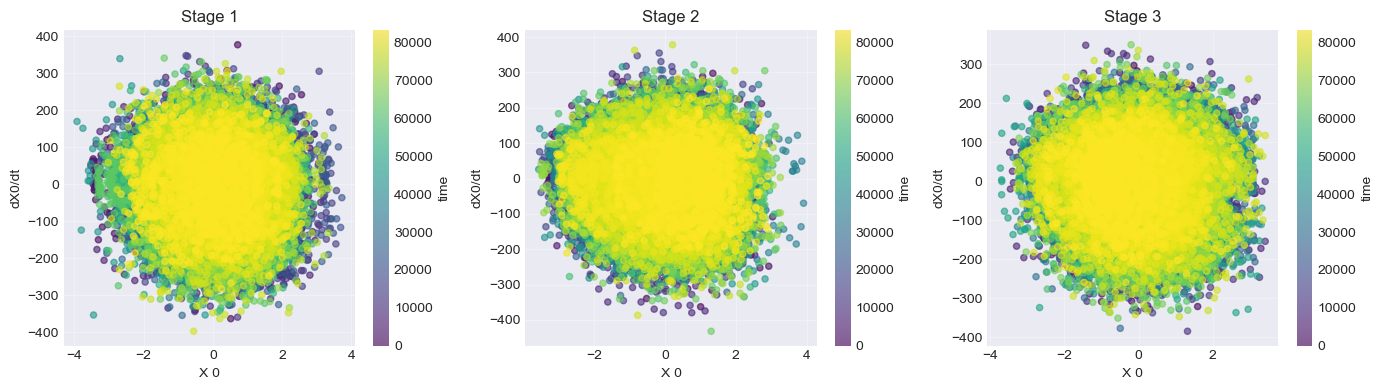

✓ 相空间轨迹绘制完成


In [9]:
# 绘制相空间轨迹（X vs dX/dt）
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
feature = 0

for idx, stage in enumerate([1, 2, 3]):
    X_train = timeseries_data[stage]['train']['X']
    X_dot_train = timeseries_data[stage]['train']['X_dot']
    
    # 绘制相空间轨迹
    scatter = axes[idx].scatter(X_train[feature], X_dot_train[feature], 
                                c=range(len(X_train[feature])), cmap='viridis', 
                                s=20, alpha=0.6)
    axes[idx].set_xlabel(f'X {feature}')
    axes[idx].set_ylabel(f'dX{feature}/dt')
    axes[idx].set_title(f'Stage {stage}')
    axes[idx].grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[idx])
    cbar.set_label('time')

plt.tight_layout()
plt.show()

print("✓ 相空间轨迹绘制完成")

## 步骤 7: 统计信息

In [8]:
print("\n" + "="*60)
print("时间序列数据统计")
print("="*60)

for stage in [1, 2, 3]:
    print(f"\nStage {stage}:")
    
    # 训练集统计
    X_train = timeseries_data[stage]['train']['X']
    X_dot_train = timeseries_data[stage]['train']['X_dot']
    
    print(f"  训练集:")
    print(f"    X 形状: {X_train.shape} (特征数, 时间步数)")
    print(f"    X 均值: {X_train.mean():.6f}, 方差: {X_train.std():.6f}")
    print(f"    dX/dt 均值: {X_dot_train.mean():.6f}, 方差: {X_dot_train.std():.6f}")
    
    # 测试集统计
    X_test = timeseries_data[stage]['test']['X']
    X_dot_test = timeseries_data[stage]['test']['X_dot']
    
    print(f"  测试集:")
    print(f"    X 形状: {X_test.shape}")
    print(f"    X 均值: {X_test.mean():.6f}, 方差: {X_test.std():.6f}")
    print(f"    dX/dt 均值: {X_dot_test.mean():.6f}, 方差: {X_dot_test.std():.6f}")


时间序列数据统计

Stage 1:
  训练集:
    X 形状: (141, 83261) (特征数, 时间步数)
    X 均值: 0.145113, 方差: 0.969457
    dX/dt 均值: 0.477104, 方差: 74.011985
  测试集:
    X 形状: (141, 2995)
    X 均值: 0.259213, 方差: 0.860735
    dX/dt 均值: 0.974380, 方差: 68.138424

Stage 2:
  训练集:
    X 形状: (141, 83261) (特征数, 时间步数)
    X 均值: -0.078808, 方差: 1.056293
    dX/dt 均值: -0.302527, 方差: 72.410528
  测试集:
    X 形状: (141, 2995)
    X 均值: -0.055836, 方差: 0.995932
    dX/dt 均值: -1.299762, 方差: 66.179401

Stage 3:
  训练集:
    X 形状: (141, 83261) (特征数, 时间步数)
    X 均值: -0.007929, 方差: 0.956397
    dX/dt 均值: 0.230974, 方差: 72.095525
  测试集:
    X 形状: (141, 2995)
    X 均值: -0.121139, 方差: 1.072889
    dX/dt 均值: 0.621388, 方差: 65.991329


## 步骤 8: 数据准备完成 - 可直接用于 pysindy

In [13]:
x_data = timeseries_data[stage]['train']['X'].T
micro_name = []
for i in range(x_data.shape[1]):
    micro_name.append('x'+str(i))
micro_name

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'x39',
 'x40',
 'x41',
 'x42',
 'x43',
 'x44',
 'x45',
 'x46',
 'x47',
 'x48',
 'x49',
 'x50',
 'x51',
 'x52',
 'x53',
 'x54',
 'x55',
 'x56',
 'x57',
 'x58',
 'x59',
 'x60',
 'x61',
 'x62',
 'x63',
 'x64',
 'x65',
 'x66',
 'x67',
 'x68',
 'x69',
 'x70',
 'x71',
 'x72',
 'x73',
 'x74',
 'x75',
 'x76',
 'x77',
 'x78',
 'x79',
 'x80',
 'x81',
 'x82',
 'x83',
 'x84',
 'x85',
 'x86',
 'x87',
 'x88',
 'x89',
 'x90',
 'x91',
 'x92',
 'x93',
 'x94',
 'x95',
 'x96',
 'x97',
 'x98',
 'x99',
 'x100',
 'x101',
 'x102',
 'x103',
 'x104',
 'x105',
 'x106',
 'x107',
 'x108',
 'x109',
 'x110',
 'x111',
 'x112',
 'x113',
 'x114',
 'x115',
 'x116',
 'x117',
 'x118',
 'x119',
 'x120',
 'x121',
 'x122',
 'x

# 选择观测函数

In [14]:
n_delays = 2
delay_interval = 24
H, new_names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
x_data_lift = H
H.shape, new_names

((83213, 423),
 ['x0',
  'x1',
  'x2',
  'x3',
  'x4',
  'x5',
  'x6',
  'x7',
  'x8',
  'x9',
  'x10',
  'x11',
  'x12',
  'x13',
  'x14',
  'x15',
  'x16',
  'x17',
  'x18',
  'x19',
  'x20',
  'x21',
  'x22',
  'x23',
  'x24',
  'x25',
  'x26',
  'x27',
  'x28',
  'x29',
  'x30',
  'x31',
  'x32',
  'x33',
  'x34',
  'x35',
  'x36',
  'x37',
  'x38',
  'x39',
  'x40',
  'x41',
  'x42',
  'x43',
  'x44',
  'x45',
  'x46',
  'x47',
  'x48',
  'x49',
  'x50',
  'x51',
  'x52',
  'x53',
  'x54',
  'x55',
  'x56',
  'x57',
  'x58',
  'x59',
  'x60',
  'x61',
  'x62',
  'x63',
  'x64',
  'x65',
  'x66',
  'x67',
  'x68',
  'x69',
  'x70',
  'x71',
  'x72',
  'x73',
  'x74',
  'x75',
  'x76',
  'x77',
  'x78',
  'x79',
  'x80',
  'x81',
  'x82',
  'x83',
  'x84',
  'x85',
  'x86',
  'x87',
  'x88',
  'x89',
  'x90',
  'x91',
  'x92',
  'x93',
  'x94',
  'x95',
  'x96',
  'x97',
  'x98',
  'x99',
  'x100',
  'x101',
  'x102',
  'x103',
  'x104',
  'x105',
  'x106',
  'x107',
  'x108',
  'x1

In [22]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide + fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(83261, 423)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x136', 

# 进行拟合

In [23]:
discrete_time = True
dt = 1
thresholds = np.logspace(0, 2, 2)
print(thresholds)
model, results = fit_sindy_sr3_robust(x_data_lift, ide, new_names, penalty='l1', discrete_time=discrete_time, max_iter=300, thresholds=thresholds, metric='bic', tol=1e-4, nu=1)

[  1. 100.]
开始使用 L1 范数扫描 2 个参数...


100%|██████████| 2/2 [01:12<00:00, 36.08s/it]



最佳模型 (bic) | Penalty: l1
Param (Thr/Lam): 1.000e+00
Test MSE: 4.3330e-03
Complexity: 2195
(x0)[k+1] = 1.003 x0[k] + -0.044 x62[k] + 38286.689 x140[k] + 0.027 x125_d24[k] + -38721.775 x139_d48[k] + -44.017 x140_d48[k]
(x1)[k+1] = 0.996 x1[k] + -2492.225 x140[k] + 2520.636 x139_d48[k] + 2.878 x140_d48[k]
(x2)[k+1] = 1.001 x2[k] + -0.038 x62[k] + 22371.761 x140[k] + 0.025 x125_d24[k] + 0.019 x73_d48[k] + -22626.403 x139_d48[k] + -25.788 x140_d48[k]
(x3)[k+1] = 0.997 x3[k] + -0.039 x62[k] + 25216.576 x140[k] + 0.036 x13_d24[k] + 0.021 x125_d24[k] + 0.025 x73_d48[k] + -25503.704 x139_d48[k] + -29.101 x140_d48[k]
(x4)[k+1] = 0.906 x4[k] + -0.091 x5[k] + -0.020 x62[k] + 17688.845 x140[k] + -17888.907 x139_d48[k] + -20.183 x140_d48[k]
(x5)[k+1] = -0.028 x3[k] + -0.167 x4[k] + 0.796 x5[k] + -0.013 x107[k] + 906.810 x140[k] + -0.024 x73_d48[k] + -916.541 x139_d48[k] + -0.953 x140_d48[k]
(x6)[k+1] = 0.963 x6[k] + -0.065 x107[k] + 13435.080 x140[k] + 0.020 x12_d24[k] + -0.032 x13_d24[k] + -0.020 

In [18]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.004, max_iter=20000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=True)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=new_names)
model.print()

(x0)' = 0.001 x1 + 0.004 x6 + 0.005 x61 + -0.040 x62 + 0.003 x94 + 0.004 x95 + 0.014 x98 + 0.001 x109 + 0.002 x127 + 0.001 x132 + -0.001 x0_d24 + -0.002 x1_d24 + -0.005 x0_d48
(x1)' = 0.001 x1 + 0.002 x6 + 0.002 x7 + 0.001 x15 + -0.015 x62 + 0.003 x93 + 0.003 x95 + 0.005 x98 + -0.004 x107 + 0.001 x109 + -0.004 x1_d24 + 0.002 x107_d24 + -0.005 x1_d48
(x2)' = 0.005 x1 + 0.001 x6 + 0.003 x61 + -0.034 x62 + 0.004 x94 + 0.005 x95 + 0.010 x98 + 0.013 x107 + 0.001 x127 + -0.009 x1_d24 + -0.001 x14_d24 + -0.003 x2_d48
(x3)' = 0.001 x8 + 0.001 x9 + 0.005 x61 + -0.041 x62 + 0.001 x63 + 0.004 x94 + 0.005 x95 + 0.012 x98 + 0.018 x107 + 0.001 x109 + -0.001 x1_d24 + -0.003 x4_d24 + -0.001 x132_d24 + -0.002 x2_d48 + -0.001 x3_d48
(x4)' = 0.001 x9 + 0.001 x16 + -0.002 x62 + -0.005 x4_d24 + -0.001 x6_d24 + -0.002 x3_d48 + -0.001 x107_d48
(x5)' = -0.002 x3 + -0.001 x8 + 0.016 x62 + -0.002 x94 + -0.004 x95 + -0.002 x98 + -0.023 x107 + 0.007 x4_d24 + 0.001 x3_d48
(x6)' = 0.002 x39 + 0.012 x62 + -0.107 x10

In [24]:
model.score(x_data_lift, t=dt)

0.9894174514444941

# 多步预测

In [28]:
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]
step_pred = 10
t = range(step_pred)

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(10, 423)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_77883/1394354138.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


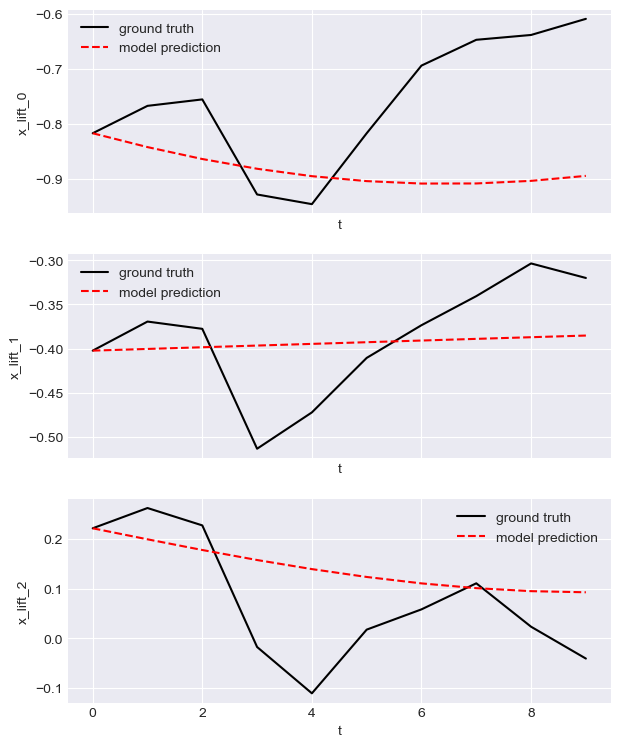

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()